
# Data Cleaning & Exploratory Data Analysis

This notebook performs data cleaning and exploratory data analysis (EDA) on the **synthetic pharma sales dataset**. We begin by loading the raw transaction data and examining its structure. After applying a basic set of cleaning rules, we explore high‑level patterns using a series of visualisations: monthly sales trends, top products, an ATC breakdown, seasonality curves, and the relationship between price and demand.



## Dataset Description

The raw dataset `pharma_sales.csv` contains daily transactional records from **1 January 2020** through **31 December 2024**. Each row represents sales of a single product at a retailer on a specific date. The columns are:

| Column           | Description                                           |
|------------------|-------------------------------------------------------|
| `date`           | Calendar date of the transaction                      |
| `product_id`     | Unique identifier for each product                    |
| `product_name`   | Descriptive name of the product                       |
| `atc_code`       | Anatomical Therapeutic Chemical classification code   |
| `region`         | Geographic region of the sale                         |
| `retailer_id`    | Unique identifier of the retailer                     |
| `units_sold`     | Number of units sold on that date                    |
| `unit_price`     | Selling price per unit (before discount)              |
| `discount_pct`   | Percentage discount applied (0–100%)                  |
| `promotion_flag` | Binary indicator (1 if the product was promoted)      |
| `sales_value`    | Revenue from the sale (units × price × (1 − discount)) |

The dataset exhibits seasonality (e.g. cold/flu season peaks early in the year and allergy medications peak mid‑year), modest year‑over‑year growth, and occasional promotional lifts.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.max_columns', None)

raw_path = Path('..') / 'data' / 'raw' / 'pharma_sales.csv'
df_raw = pd.read_csv(raw_path, parse_dates=['date'])

print('Raw data shape:', df_raw.shape)
df_raw.head()


Raw data shape: (501046, 11)


,date,product_id,product_name,atc_code,region,retailer_id,units_sold,unit_price,discount_pct,promotion_flag,sales_value
0,2020-04-03,GEN-52,Generic Painkiller 52,N02BE/B,West Midlands,R1004,6,3.49,0.0,0,20.94
1,2023-08-30,M01AE-01,Ibuprofen 200mg,M01AE,Yorkshire & Humber,R1006,3,5.37,0.0,0,16.11
2,2024-03-03,GEN-64,Generic Painkiller 64,N02BE/B,South West,R1012,7,3.35,0.0,0,23.42
3,2020-09-28,M01AE-07,Fenbufen,M01AE,East of England,R1003,1,5.73,0.0,0,5.73
4,2021-10-05,R03-05,Ipratropium,R03,East Midlands,R1025,2,14.63,0.0,0,29.26


In [2]:

# Display the tail of the dataset
print('Tail of raw data:')
df_raw.tail()

print('Data types:')
print(df_raw.dtypes)

# Missingness per column
missing = df_raw.isna().sum().rename('missing_count')
missing


Tail of raw data:
Data types:
date              datetime64[ns]
product_id                object
product_name              object
atc_code                  object
region                    object
retailer_id               object
units_sold                 int64
unit_price               float64
discount_pct             float64
promotion_flag             int64
sales_value              float64
dtype: object


date              0
product_id        0
product_name      0
atc_code          0
region            0
retailer_id       0
units_sold        0
unit_price        0
discount_pct      0
promotion_flag    0
sales_value       0
Name: missing_count, dtype: int64


### Cleaning Strategy

The raw data appears largely complete, but a systematic cleaning pipeline is applied to ensure data quality. We remove rows with nulls in critical fields (`date`, `product_id`, `region`, `retailer_id`, `units_sold`, `unit_price`, `sales_value`), filter out transactions with non‑positive units or negative prices/sales, and normalise text fields by stripping extra whitespace.


In [3]:

before_rows = len(df_raw)

df_clean = df_raw.dropna(subset=['date','product_id','region','retailer_id','units_sold','unit_price','sales_value'])
df_clean = df_clean[(df_clean['units_sold'] > 0) & (df_clean['unit_price'] >= 0) & (df_clean['sales_value'] >= 0)]
for col in ['product_id','product_name','atc_code','region','retailer_id']:
    df_clean[col] = df_clean[col].astype(str).str.strip()

after_rows = len(df_clean)
print(f"Rows before cleaning: {before_rows}")
print(f"Rows after cleaning:  {after_rows}")
print(f"Rows removed:        {before_rows - after_rows}")

df_clean.head()


Rows before cleaning: 501046
Rows after cleaning:  501046
Rows removed:        0


,date,product_id,product_name,atc_code,region,retailer_id,units_sold,unit_price,discount_pct,promotion_flag,sales_value
0,2020-04-03,GEN-52,Generic Painkiller 52,N02BE/B,West Midlands,R1004,6,3.49,0.0,0,20.94
1,2023-08-30,M01AE-01,Ibuprofen 200mg,M01AE,Yorkshire & Humber,R1006,3,5.37,0.0,0,16.11
2,2024-03-03,GEN-64,Generic Painkiller 64,N02BE/B,South West,R1012,7,3.35,0.0,0,23.42
3,2020-09-28,M01AE-07,Fenbufen,M01AE,East of England,R1003,1,5.73,0.0,0,5.73
4,2021-10-05,R03-05,Ipratropium,R03,East Midlands,R1025,2,14.63,0.0,0,29.26



## Exploratory Analysis

With the cleaned dataset in hand, we explore key patterns in the sales. The following plots summarise the data:

- **Monthly Total Sales** show the aggregate revenue across all products and regions.
- **Top 20 Products** identify the leading revenue contributors.
- **ATC Breakdown** illustrates the distribution of sales by therapeutic class.
- **Seasonality Curve** shows average sales by month to reveal seasonal patterns.
- **Price vs Demand** explores the relationship between unit price and quantity sold.

Each chart is accompanied by a brief observation.


In [4]:

df_clean['month'] = df_clean['date'].dt.to_period('M').dt.to_timestamp()
agg_df = df_clean.groupby(['month','product_id','product_name','atc_code','region']).agg(
    total_units=('units_sold','sum'),
    total_sales=('sales_value','sum'),
    avg_unit_price=('unit_price','mean'),
    promo_days=('promotion_flag','sum'),
).reset_index()

monthly_totals = agg_df.groupby('month')['total_sales'].sum().reset_index()
monthly_totals.head()


,month,total_sales
0,2020-01-01,129798.17
1,2020-02-01,125415.83
2,2020-03-01,135570.95
3,2020-04-01,114595.56
4,2020-05-01,116317.10


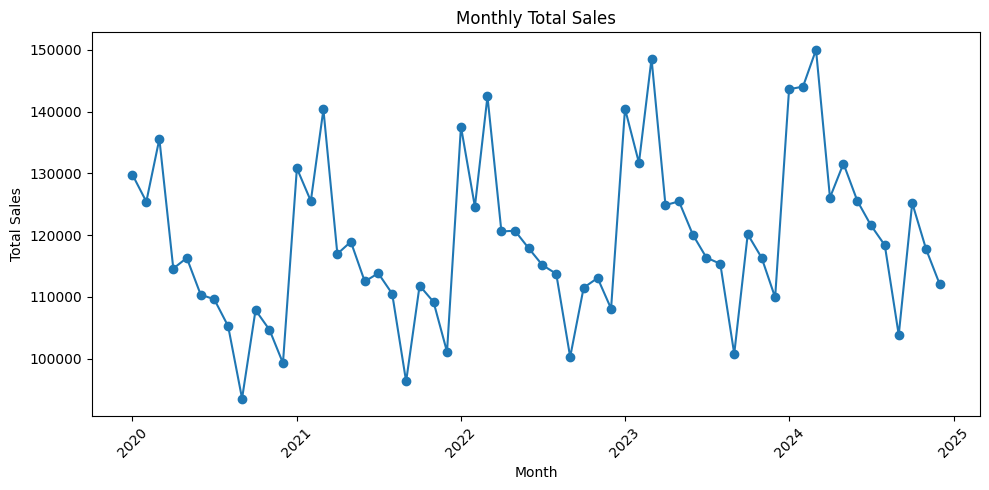

In [5]:

plt.figure(figsize=(10,5))
plt.plot(monthly_totals['month'], monthly_totals['total_sales'], marker='o')
plt.title('Monthly Total Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



The monthly sales plot reveals clear seasonality with peaks in the early months of each year (cold/flu season) and a secondary rise during the summer months (allergy season). A modest upward trend over the five‑year period indicates year‑over‑year growth in the synthetic dataset.


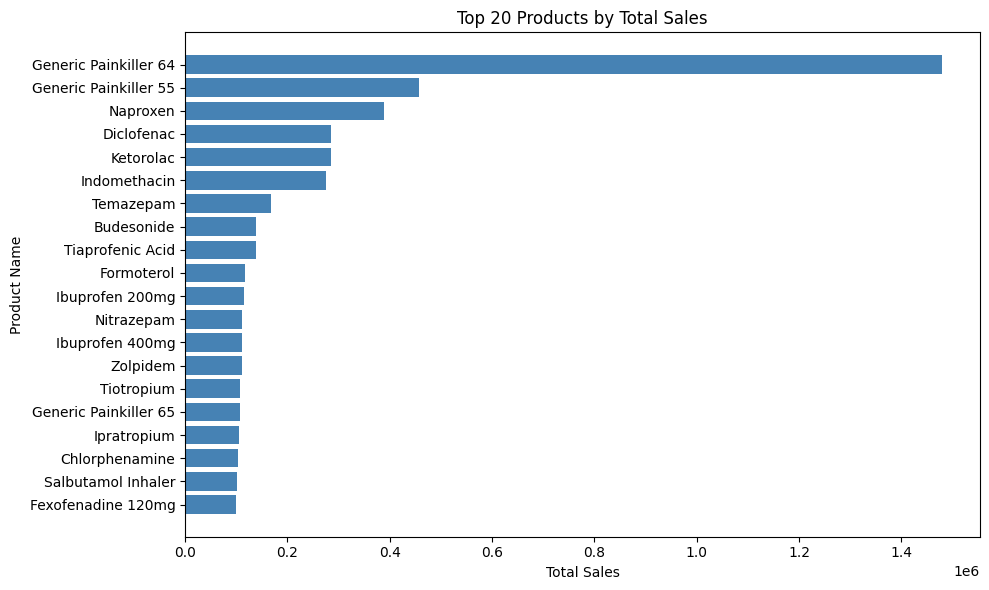

In [6]:

top_products = agg_df.groupby('product_name')['total_sales'].sum().nlargest(20).reset_index()

plt.figure(figsize=(10,6))
plt.barh(top_products['product_name'], top_products['total_sales'], color='steelblue')
plt.title('Top 20 Products by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Name')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



A small number of products contribute a disproportionately large share of revenue. Understanding which SKUs drive the business is crucial for portfolio management and promotional planning.


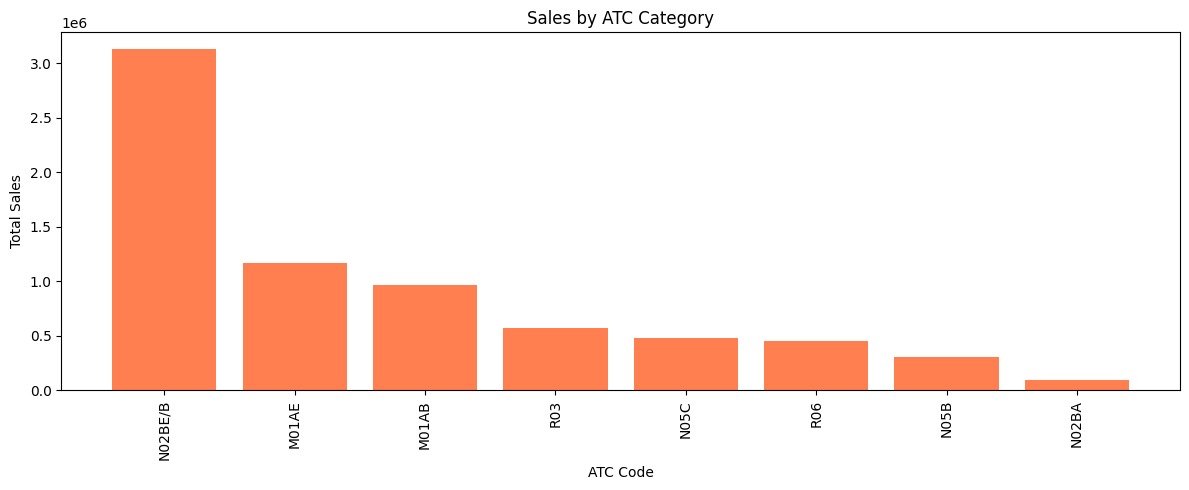

In [7]:

atc_totals = agg_df.groupby('atc_code')['total_sales'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12,5))
plt.bar(atc_totals['atc_code'], atc_totals['total_sales'], color='coral')
plt.title('Sales by ATC Category')
plt.xlabel('ATC Code')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



The ATC breakdown chart highlights which therapeutic classes dominate revenue. Analgesics and respiratory treatments, for example, often appear near the top of the ranking.


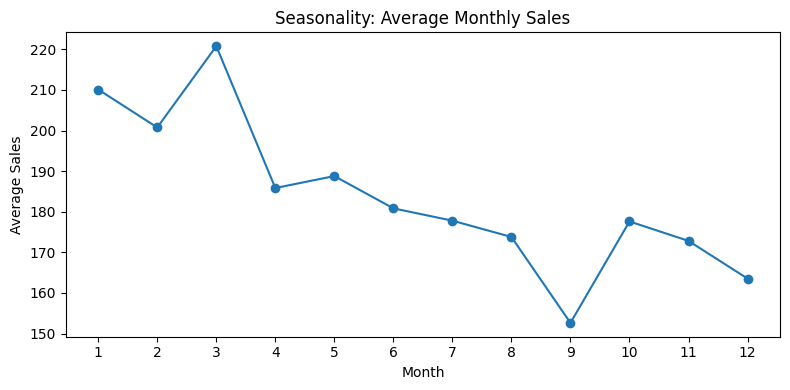

In [8]:

agg_df['month_num'] = agg_df['month'].dt.month
seasonality = agg_df.groupby('month_num')['total_sales'].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(seasonality['month_num'], seasonality['total_sales'], marker='o')
plt.title('Seasonality: Average Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()



Average monthly sales peak in January–March and again in late spring, reflecting the simulated cold/flu and allergy seasons. Sales are comparatively lower towards the end of the year.


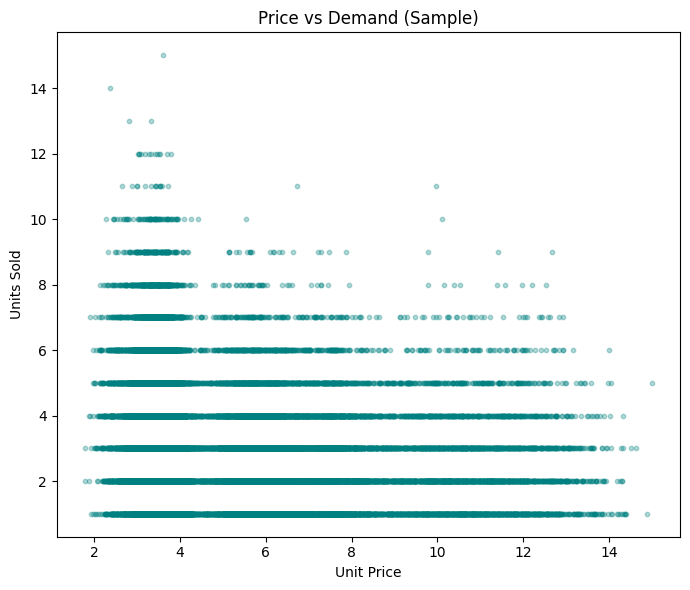

In [9]:

sample_df = df_clean.sample(n=min(40000, len(df_clean)), random_state=42)

plt.figure(figsize=(7,6))
plt.scatter(sample_df['unit_price'], sample_df['units_sold'], s=10, alpha=0.3, color='teal')
plt.title('Price vs Demand (Sample)')
plt.xlabel('Unit Price')
plt.ylabel('Units Sold')
plt.tight_layout()
plt.show()



While there is some inverse relationship between price and units sold, the correlation is not overly strong, indicating modest price elasticity in the synthetic market. Promotions (not explicitly shown here) can further influence demand.
